## Estados, sucesores y caminos

Empezamos las definiciones. Un **estado** es la representación de los elementos que describen un problema concreto en un momento dado. En este documento, los estados de un problema se representan como una subclase de la clase `BaseState`, cuya implementación es la siguiente:

```python
class BaseState(metaclass=abc.ABCMeta):

    @abc.abstractmethod
    def successors(self):
        raise NotImplementedError()

    @abc.abstractmethod
    def equals(self, other):
        raise NotImplementedError()

    def __eq__(self, other):
        return self.equals(other)
```

Esta implementación (localizada en el fichero `search/__init__.py` obliga a que las implementaciones concretas de los problemas definan los métodos de _igualdad_ (para identificar cuando dos estados son iguales) y _sucesores_.

Los **sucesores** son aquellos estados a los que se puede llegar desde el estado actual aplicando las reglas de transición. El método `successors` se encargará precisamente de aplicar las reglas de transición del problema en concreto para generar una lista de los estados alcanzables desde el actual.

Por último, representaremos los **caminos** como una lista de nodos. Por ejemplo:

```python
camino = [n1, n2, n3]
```

Se correspondería con el siguiente camino:

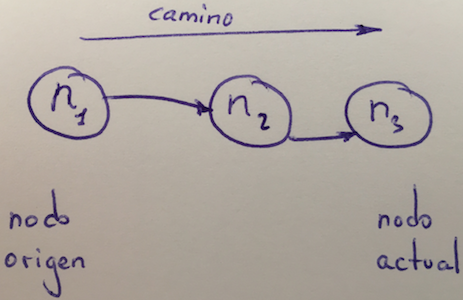

## Algoritmo base

El algoritmo base abstrae las características generales de estos tipos de algoritmos.

Funcionan siempre de la misma manera: se parte de una lista con un único nodo, denominado **origen**. Después extraen el primer camino de la lista de caminos pendientes y si no es **solución**, lo expanden en base a sus **reglas de transición**, integran dichas expansiones en la lista de caminos pendientes y vuelve a iterar. Así hasta que encuentra la solución o hasta que no hay más caminos que explorar.

El siguiente código muestra un ejemplo de un algoritmo de búsqueda en espacios de estados.

In [1]:
def search(algorithm, origin, solution):
    # La lista de caminos pendientes se inicia con el estado origen.
    cp = [[origin]]

    # Repetimos el algoritmo mientras haya caminos pendientes.
    while cp:

        # Cogemos el primer camino de la lista de caminos pendientes
        path = cp.pop(0)

        if solution(path):
            # Genial, hemos terminado
            return path
        else:
            # Vaya, seguimos buscando por los sucesores. Expandimos...
            last_state = path[-1]
            e = []
            for state in last_state.successors():
                if state not in path:  # Así evitamos caminos cíclicos
                    expansion = path + [state]
                    e.append(expansion)
            # ... y concatenamos según diga el algoritmo
            cp = algorithm(cp, e)

    # Si hemos salido del bucle, es porque no había ningún camino que
    # llegase al resultado
    return False

El parámetro `algorithm` de la función determinará el algoritmo concreto con el que se combinarán la lista de caminos pendientes con las expansiones, y como el algoritmo base, es completamente independiente del problema.

Los parámetros `origin` y `solution` son la parte dependiente del problema. El primero indica el estado de inicio de nuestro algoritmo (el nodo desde donde comenzamos a buscar en el espacio de estados), y el segundo será la función que nos indique si hemos llegado o no a una solución.

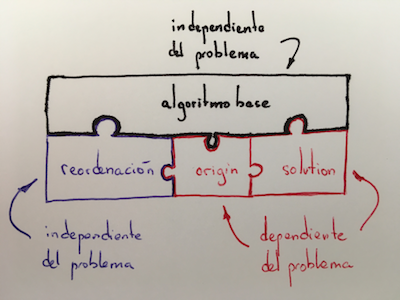

## Algoritmos de recombinación

Hemos indicado que el algoritmo concreto de reordenación o recombinación es una función que pasamos por el parámetro `algorithm`. En concreto esta función deberá tomar como entrada la lista de caminos pendientes y de expansiones, y devolver una nueva lista de caminos pendientes.

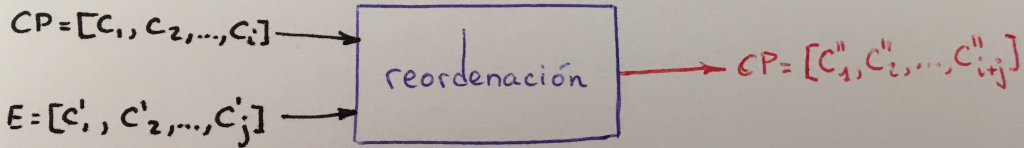

El comportamiento del algoritmo de búsqueda al final viene determinado por la forma en que este algoritmo de recombinación ordena los caminos pendientes y la expansión de los sucesores. A continuación se presentan ejemplos de implementaciones para los algoritmos vistos en clase.

### Búsqueda en profundidad

La búsqueda en profundidad consiste en explorar siempre primero los caminos expandidos. De esta manera exploramos "en profundidad" el árbol.

In [2]:
def depth_search(cp, e):
    """ Exploración en profundidad.

    :param cp: La lista de caminos pendientes.
    :param e: La lista de caminos expansión.
    """
    return e + cp

Si nos fijamos, la lista de caminos pendientes se genera poniendo las nuevas expansiones (por definición los más profundos) por delante de los demás caminos pendientes.

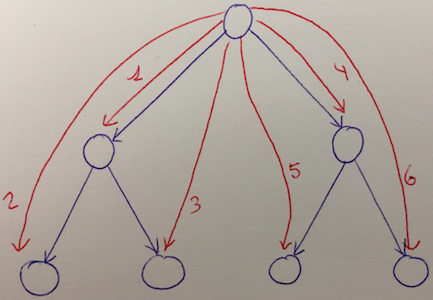

Es el mismo concepto a recorrer en profundidad un árbol, donde se exploran los caminos llegando hasta las hojas.

### Búsqueda en amplitud

Este es justo el caso contrario. La busqueda se realiza primero por los caminos más cercanos y se va incrementando la profundidad a medida que éstos se van van explorando.

In [3]:
def breadth_search(cp, e):
    """ Exploración en amplitud.

    :param cp: La lista de caminos pendientes.
    :param e: La lista de caminos expansión.
    """
    return cp + e

La lista de caminos pendientes se genera poniendo al final las expansiones. De esta manera garantizamos que se exploran primero los caminos más cortos frente a los que adentran más en el espacio de estados.

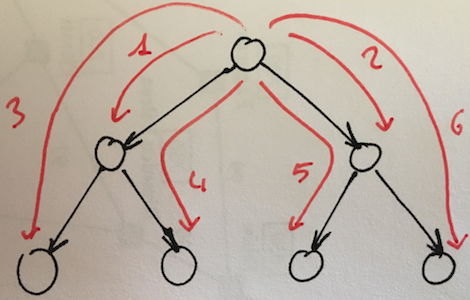

Es el concepto de recorrido en anchura de un árbol. En éste, los nodos más cercanos a la raíz son los primeros a explorar.

### Método de la escalada

El _método de la escalada_ es el primero de los algoritmos que vemos que usa el concepto de _heurística_, y por tanto el primero que consideramos _Inteligencia Artificial_.

Reordena la expansión generada en función de su heurística, para posteriormente concatenar la lista de caminos pendientes.

La **heurística** es una función que nos estima lo próxima que está la solución de nuestro estado actual. Por ello, podemos representar la función heurística como aquella función que recibe un estado y devuelve un valor de $0$ a $\inf$ donde los valores más bajos indican más proximidad a la solución.

```python
def heuristic(state):
    # Operations and stuff
    return estimation_to_reach_the_goal
```

Como nuestra función de recombinación espera dos listas de caminos, tenemos que hacer un pequeño truco. Crearemos una función a la que le pasaremos la heurística, y esta función devolverá otra función con la firma (los parámetro de entrada y salida) que necesitamos.

In [4]:
def hill_climbing(heuristic):
    """ Método de la escalada.

    :param heuristic: Función que nos da la calidad de un estado en concreto.
    :return: La función de recombinación de caminos pendientes y expansiones.
    """

    def f(cp, e):
        order = lambda path: heuristic(path[-1])
        return sorted(e, key=order) + cp

    return f

De esta manera, podemos usar el método de la escalada con cualquier heurística dependiente del problema sin modificar el código independiente.

### "Primero el Mejor"

El algoritmo de _primero el mejor_ es muy similar al método de la escalada. La única diferencia es que, mientras que en el método anterior primero se ordenaban las expansiones y luego se concatenaba con caminos pendientes, ahora **primero se concatenan caminos pendientes y expansiones y luego se ordena por heurística**.

In [5]:
def best_first(heuristic):
    """ Método de "Primero el mejor".

    :param heuristic: Función que nos da la calidad de un estado en concreto.
    :return: La función de recombinación de caminos pendientes y expansiones.
    """

    def f(cp, e):
        order = lambda path: heuristic(path[-1])
        return sorted(cp + e, key=order)

    return f

### Branch and bound

Con el método de _branch and bound_ se introducen dos conceptos, el del _coste_ y el de _poda_.

El **coste** es un valor asociado a la transición de un nodo a otro y nos indica, precisamente, lo que cuesta pasar de uno a otro estado. Cuanto mayor es el valor, mayor es el coste. En los problemas en los que se tienen en cuenta el coste, lo general es buscar el menor coste para llegar de un estado inicial a la solución.

Al igual que con la heurística, podemos representar la función de coste como aquella función que recibe un camino y devuelve un valor de $0$ a $\inf$ donde los valores más bajos indican menor coste.

```python
def cost(path):
    # Operations and stuff
    return how_much_does_the_path_cost
```

La **poda** es inherente al concepto de coste. Es como se denomina a la eliminación de caminos que llegan a estados a los que se llega por otros caminos con menos coste. Como el objetivo es llegar a un estado solución con el menor coste posible, si en algún momento se conocen dos caminos para llegar de un estado a otro, se eliminará aquel con mayor coste asociado. Una posible implementación de la poda es la siguiente:

In [6]:
def bound(paths):
    """ Realiza una poda sobre una lista de caminos.

    Se espera que el conjunto de caminos esté ordenado por coste. En caso de
    no ser así, existe la posibilidad de podar caminos con un coste menor.

    :param paths: Una lista de caminos por explorar ordenados por coste.
    :return: La lista de caminos después de excluir los podados.
    """
    bounded_paths = []
    reached_nodes = []
    for path in paths:
        last_node = path[-1]
        if last_node not in reached_nodes:
            # Sólo lo añadimos si no ha sido alcanzado antes
            reached_nodes.append(last_node)
            bounded_paths.append(path)
    return bounded_paths

El método _branch and bound_ utiliza _coste_ y _poda_. Al igual que en el _método de la escalada_ o en _primero el mejor_, crearemos una función que espera una función de coste. Ésta nos devolverá la función que implementa la reordenación de los caminos pendientes y las expansiones teniendo en cuenta la función de coste.

In [7]:
def branch_and_bound(cost):
    """ Método "Branch and bound".

    :param cost: Función que nos da el coste de un camino en concreto.
    :return: La función de recombinación de caminos pendientes y expansiones.
    """

    def f(cp, e):
        order = lambda path: cost(path)
        return bound(sorted(cp + e, key=order))

    return f

El funcionamiento es similar al método _primero el mejor_ pero ordenando por coste en lugar de por heurística y usando poda.

Al ordenar siempre por el coste, nos garantiza que llegará a la solución única, pero **no lo consideramos inteligencia artificial porque no existe ninguna heurística que guíe su funcionamiento**.

### A*

El método A\* combina los conceptos de coste y heurística en un único método. Su funcionamiento es el mismo que el del método _branch and bound_, con la diferencia que en lugar de ordenar por coste, ordenamos por una combinación de heurística y coste, denominada estimador, que tiene la siguiente forma:

$h^*(x) = g(x) + \alpha h(x)$

Donde $g(x)$ sería la función de coste, $h(x)$ la función heurística y $\alpha$ el factor que pondera la importancia de la heurística.

In [8]:
def a_star(cost=None, heuristic=None, alpha=None):
    """ Método "A*".

    Se efectuará con una función de estimación de la forma:
    
    h*(s) = cost(s) + alpha * heuristic(s)

    :param cost: Función que nos da el coste de un camino en concreto.
    :param heuristic: Función que nos da la calidad de un estado en concreto.
    :param alpha: El grado de importancia de la heurística frente al coste.
    :return: La función de recombinación de caminos pendientes y expansiones.
    """
    alpha = alpha or 1.0
    
    def f(cp, e):
        order = lambda path: cost(path) + alpha * heuristic(path[-1])

        return bound(sorted(cp + e, key=order))

    return f

En la implementación que hemos hecho de ejemplo, podemos ver que se ha añadido además un parámetro alpha para darle más o menos importancia al heurístico respecto al coste.

Este método además nos garantizará el camino de menor coste siempre y cuando cumplamos la **condición de minorancia** (también conocido como _heurística admisible_).

## Problemas de ejemplo

A continuación se realizarán algunos problemas para ilustrar cómo trabajan los algoritmos de búsqueda en espacios de estados.

El funcionamiento es exactamente el mismo en todos los problemas. Hay que programar la parte dependiente del problema, la cual es el estado (clase `State`), el cálculo de sucesores (el método `successors` de la clase `State`) y la solución (una función booleana), establecer cuál es el estado inicial y combinarlo con el algoritmo de búsqueda.

El algoritmo nos devolverá un camino si lo encuentra, y si no devolverá `False`, por lo que importaremos una función para imprimirlos correctamente.

In [9]:
from search.utils import print_path

### Problema de las dos vasijas

El problema de las dos vasijas se enuncia como sigue:

> Tenemos dos jarras vacías, una de 4 litros y otra de 3 litros de capacidad, y un grifo con el que podemos llenarlas. El objetivo es conseguir tener 2 litros de agua en la jarra de 4 litros, con el inconveniente de que ninguna de las jarras tiene marcas que nos permitan conocer la cantidad de agua que contienen.

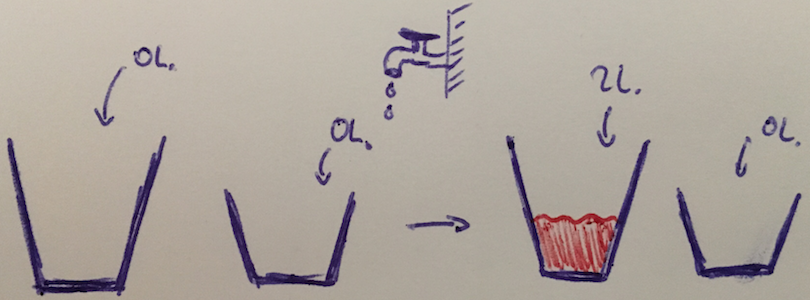

> Por tanto, Las únicas acciones que podemos realizar es vaciar totalmente las jarras, llenarlas hasta el máximo de su capacidad o volcar el contenido de una a otra hasta que una se vacía o la otra se llena completamente.

Este problema se puede representar como una exploración en un espacio de estados. Como ya disponemos de los algoritmos de búsqueda, sólo nos tenemos que preocupar de la representación de cada estado, la generación de sucesores y la solución.

#### Representación de cada estado del problema

La clase `State` que representará los estados contendrá una lista de la cantidad de agua que tiene cada vasija. El constructor de la clase será la capacidad máxima de las vasijas (y opcionalmente el estado inicial). Por ejemplo:

```python
# Dos vasijas vacías, una de 4 litros y otra de 3 litros
state = State([4, 3])

# Dos vasijas, una de 4 litros y otra de 3 litros, ambas llenas con 1 litro de agua
state = State([4, 3], [1, 1])
```

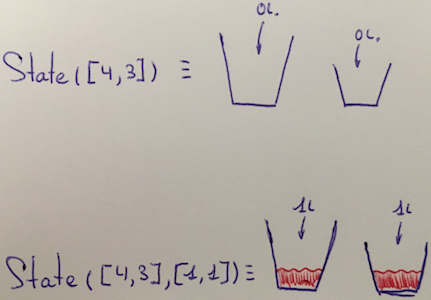

#### Generación de los sucesores

El método `successors` de la clase `State` devolverá una lista con los sucesores válidos calculados de la siguiente manera:

1. Los estados de rellenar las vasijas hasta su máxima capacidad.
2. Los estados de vaciar las vasijas completamente.
3. Los estados de vaciar el contenido de una vasija en otra hasta que, o bien se vacíe la de origen completamente o bien hasta que se llene la de destino completamente.

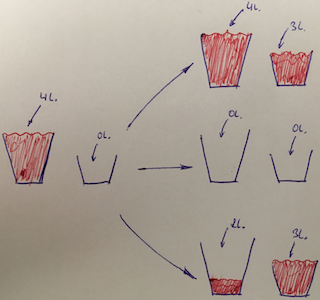

#### Solución

La solución comprobará que las jarras están a la capacidad indicada. Para generalizar la cantidad de agua del estado objetivo, la hemos implementado de la siguiente manera:

```python
def solution(jars_config):
    def f(path):
        last_state = path[-1]
        return last_state.jars == jars_config

    return f
```

Así tenemos una función solución con cualquier configuración.

In [10]:
from search.jars import State, solution

Las capacidades de las jarras y el estado final que se perseguirán serán los siguientes:

In [11]:
capacities = [4, 3]
aim = [2, 0]

Vamos a comenzar realizando, por ejemplo, una búsqueda en profundidad del problema tal y como está especificado en el enunciado:

In [12]:
origin = State(capacities)

path = search(
    origin=origin,
    solution=solution(aim),
    algorithm=depth_search,
)

print_path(path)

Step 1 	[0 0]
Step 2 	[4 0]
Step 3 	[4 3]
Step 4 	[0 3]
Step 5 	[3 0]
Step 6 	[3 3]
Step 7 	[4 2]
Step 8 	[0 2]
Step 9 	[2 0]


El algoritmo de búsqueda en profundidad encuentra la solución (si el problema tiene solución, siempre lo hace), pero desde luego comete errores innecesarios, como por ejemplo los pasos 2 y 4 (llena y vacía la primera vasija).

En el caso de la búsqueda en amplitud, no tiene ese comportamiento.

In [13]:
origin = State(capacities)

path = search(
    origin=origin,
    solution=solution(aim),
    algorithm=breadth_search,
)

print_path(path)

Step 1 	[0 0]
Step 2 	[0 3]
Step 3 	[3 0]
Step 4 	[3 3]
Step 5 	[4 2]
Step 6 	[0 2]
Step 7 	[2 0]


Sin embargo, aunque aquí no ocurra lo mismo, la búsqueda en amplitud no nos garantiza el camino óptimo. De hecho, la palabra *óptimo* sólo tiene sentido si definimos un coste para las transiciones, porque sólo así somos capaces de ordenar caminos de menos a más coste.

Parece lógico definir el coste como el número de transiciones. De esta manera, podemos definir el camino óptimo como el que menos pasos hasta la solución conlleva:

In [14]:
def num_steps_cost(path):
    ''' Coste de un camino como el número de pasos realizados en este.
    
    :param path: El camino del que calcular el coste.
    :return: Un valor entero en [0, +inf) con el coste del camino.
    '''
    return len(path)

El algoritmo `branch and bound` nos garantiza el camino óptimo dado su coste. Vamos a probarlo con nuestra nueva función de coste:

In [15]:
origin = State(capacities)

path = search(
    origin=origin,
    solution=solution(aim),
    algorithm=branch_and_bound(num_steps_cost),
)

print_path(path, cost=num_steps_cost)

Step 1 	[0 0]
Step 2 	[0 3]
Step 3 	[3 0]
Step 4 	[3 3]
Step 5 	[4 2]
Step 6 	[0 2]
Step 7 	[2 0]
Cost = 7


Curiosamente, el camino más corto es el mismo que en una búsqueda en amplitudo. En realidad no es tan curioso, porque al ser el coste el numero de pasos, buscamos la solución con menos pasos, y la búsqueda en amplitud comprueba siempre primero los caminos más cortos.

Si el coste en realidad fuese la cantidad de agua empleada:

In [16]:
def water_quantity_cost(path):
    ''' Coste de un camino como la cantidad de agua.
    
    :param path: El camino del que calcular el coste.
    :return: Un valor entero en [0, +inf) con el coste del camino.
    '''
    return sum([sum(state.jars) for state in path])

El camino sería distinto, ya que el concepto de _óptimo_ cambia:

In [17]:
origin = State(capacities)

path = search(
    origin=origin,
    solution=solution(aim),
    algorithm=branch_and_bound(water_quantity_cost),
)

print_path(path, cost=water_quantity_cost)

Step 1 	[0 0]
Step 2 	[4 0]
Step 3 	[1 3]
Step 4 	[1 0]
Step 5 	[0 1]
Step 6 	[4 1]
Step 7 	[2 3]
Step 8 	[2 0]
Cost = 22


Este problema en concreto no es tan complejo, pero en otros casos el espacio de estados puede ser tan grande que cualquiera de estas búsquedas sea muy costosa computacionalmente.

De hecho hemos hecho una pequeña trampa. La implementación de este problema la hemos realizado para $N$ jarras, no sólo para 2. Veamos cómo se comporta el problema cuando tenemos una configuración distinta de jarras:

In [18]:
capacities = [3, 4, 11, 69]
aim = [0, 0, 0, 12]

In [19]:
origin = State(capacities)

path = search(
    origin=origin,
    solution=solution(aim),
    algorithm=branch_and_bound(water_quantity_cost),
)

print_path(path, water_quantity_cost)

Step 1 	[0 0 0 0]
Step 2 	[0 4 0 0]
Step 3 	[3 1 0 0]
Step 4 	[0 1 0 0]
Step 5 	[0 0 0 1]
Step 6 	[0 0 11 1]
Step 7 	[0 0 0 12]
Cost = 34


Podemos observar que el tiempo de ejecución en un problema simple se puede disparar muy fácilmente.

Por tanto, vamos a ver si podemos buscar una heurística para nuestro problema que nos ayude a encontrar una solución que, si bien no tiene por qué ser la óptima, al menos sea suficientemente buena.

Por ejemplo, vamos a calcular la heurística como la diferencia entre el objetivo que perseguimos y la situación actual. Puede no ser la mejor heurística, pero parece razonable usarla como estimador del coste _"coste en agua"_:

In [20]:
def heuristic(aim):
    def f(state):
        diffs = [abs(a - b) for a, b in zip(aim, state.jars)]
        
        return sum(diffs)
    
    return f

Probaremos ahora con el método de _"primero el mejor"_ a ver si podemos llegar a una solución en un tiempo más razonable.

In [21]:
origin = State(capacities)

path = search(
    origin=origin,
    solution=solution(aim),
    algorithm=hill_climbing(heuristic(aim)),
)

print_path(path, cost=num_steps_cost, heuristic=heuristic(aim))

Step 1 	[0 0 0 0] heuristic = 12
Step 2 	[3 0 0 0] heuristic = 15
Step 3 	[0 0 0 3] heuristic = 9
Step 4 	[3 0 0 3] heuristic = 12
Step 5 	[0 0 0 6] heuristic = 6
Step 6 	[3 0 0 6] heuristic = 9
Step 7 	[0 0 0 9] heuristic = 3
Step 8 	[3 0 0 9] heuristic = 6
Step 9 	[0 0 0 12] heuristic = 0
Cost = 9


En este caso, el camino resultado nos arroja un coste elevado, pero el tiempo en obtener el camino ha sido varios órdenes de magnitud menor.

Usemos el algoritmo A* a ver si podemos ajustar ambos indicadores un poco:

In [22]:
origin = State(capacities)

path = search(
    origin=origin,
    solution=solution(aim),
    algorithm=a_star(water_quantity_cost, heuristic(aim)),
)

print_path(path, cost=water_quantity_cost, heuristic=heuristic(aim))

Step 1 	[0 0 0 0] heuristic = 12
Step 2 	[0 4 0 0] heuristic = 16
Step 3 	[3 1 0 0] heuristic = 16
Step 4 	[0 1 0 0] heuristic = 13
Step 5 	[0 0 0 1] heuristic = 11
Step 6 	[0 0 11 1] heuristic = 22
Step 7 	[0 0 0 12] heuristic = 0
Cost = 34


En un tiempo relativamente menor (alrededor de la mitad de tiempo) el algoritmo _A*_ ha llegado a la mejor solución.

###  Problema del pirata y los dinosaurios

Es el problema del barquero, el lobo, la oveja y la lechuga, pero en versión cretácica. El enunciado es el siguiente:

> Se dispone de una barca y cuatro personajes en una isla, el pirata, el tiranosaurio, el diplodocus y el aguacate. El objetivo a alcanzar es que todos los personajes acaben en la isla vecina. lo malo es que en la barca caben, como mucho, dos personajes y, evidentemente, sólo el pirata sabe tripularla.

> Para más problemas, si en la misma isla se encuentran el tiranosaurio y el diplodocus o el diplodocus y el aguacate, y no está el pirata para controlarlos tenemos un problema porque se pelean entre sí (bueno, el aguacate no pelea, pero el diplodocus se lo come, así que es un problema).

El objetivo es encontrar la secuencia de viajes que haga que todos los personajes pasen de un lado a otro de la isla sin que haya peleas.

#### Representación de cada estado del problema

Al igual que en el caso anterior, nuestra clase `State` representará los estados del problema. En este caso, cada estado será los personajes que hay en cada isla.

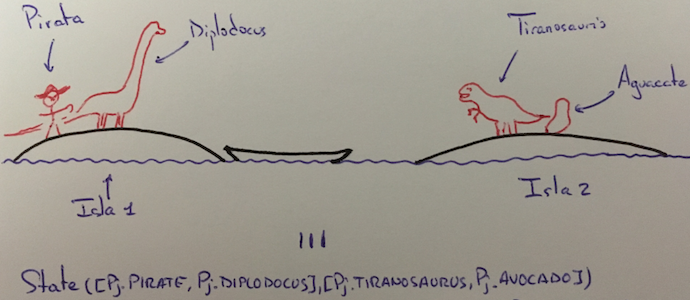

El constructor del estado recibirá una lista para cada una de las islas existentes. Por ejemplo:

```python
# Estado inicial del problema
state = State([Pj.PIRATE, Pj.DIPLODOCUS, Pj.TIRANOSAURUS, Pj.AVOCADO], [])

# Estado donde el pirata se ha llevado el aguacate
state = State([Pj.DIPLODOCUS, Pj.TIRANOSAURUS], [Pj.PIRATE, Pj.AVOCADO])
```

Por último, `Pj` es un enumerado con cada uno de los personajes que puede haber en la isla.

#### Generación de los sucesores

El método `successors` de la clase `State` devolverá una lista con los sucesores válidos calculados de la siguiente manera:

1. El estado de mover el pirata si no se producen conflictos.
2. Los estados de mover cada uno de los personajes con el pirata si son válidos.

#### Solución

La solución comprobará si hemos llegado al caso donde todos los personajes están en la isla destino. Esto se codifica de la siguiente manera:

```python
def solution(path):
    """ Tener todos los dinosaurios en la orilla derecha. """
    return not path[-1].left_shore
```

#### Ejecución de nuestra búsqueda

Comenzaremos importando los recursos necesarios y creando el estado inicial para nuestro algoritmo.

In [23]:
from search.dinosaurs import State, solution, Pj

El estado de origen será el de todos los personajes en la primera isla:

In [24]:
origin = State([Pj.PIRATE, Pj.DIPLODOCUS, Pj.TIRANOSAURUS, Pj.AVOCADO], [])

Veamos cómo se comporta la búsqueda en amplitud:

In [25]:
path = search(
    origin=origin,
    solution=solution,
    algorithm=breadth_search,
)

print_path(path)

Step 1 	[PTDA ____]
Step 2 	[_T_A P_D_]
Step 3 	[PT_A __D_]
Step 4 	[___A PTD_]
Step 5 	[P_DA _T__]
Step 6 	[__D_ PT_A]
Step 7 	[P_D_ _T_A]
Step 8 	[____ PTDA]


Y vamos a compararlo con la búsqueda en profundidad.

In [26]:
path = search(
    origin=origin,
    solution=solution,
    algorithm=depth_search,
)

print_path(path)

Step 1 	[PTDA ____]
Step 2 	[_T_A P_D_]
Step 3 	[PT_A __D_]
Step 4 	[___A PTD_]
Step 5 	[P_DA _T__]
Step 6 	[__D_ PT_A]
Step 7 	[P_D_ _T_A]
Step 8 	[____ PTDA]


Exactamente iguales. Ahora bien, si establecemos el coste como el número de viajes realizados:

In [27]:
def num_travels_cost(path):
    ''' El oste de un camino es el número de viajes con la barca.
    
    :param path: El camino del que calcular el coste.
    :return: Un valor entero en [0, +inf) con el coste del camino.
    '''
    return len(path)

¿existirá algún conjunto de viajes de menos coste?

In [28]:
path = search(
    origin=origin,
    solution=solution,
    algorithm=branch_and_bound(num_travels_cost),
)

print_path(path, cost=num_travels_cost)

Step 1 	[PTDA ____]
Step 2 	[_T_A P_D_]
Step 3 	[PT_A __D_]
Step 4 	[___A PTD_]
Step 5 	[P_DA _T__]
Step 6 	[__D_ PT_A]
Step 7 	[P_D_ _T_A]
Step 8 	[____ PTDA]
Cost = 8


Por lo visto, en este ejemplo en concreto no. Quizá si tenemos en cuenta el coste en gasolina (un diplodocus pesa ligeramente más que un aguacate, por lo que igual el coste debería ser algo mayor transportando un diplodocus) el camino resultado sería diferente (incluso más costoso de conseguir).

¿Te apetece programar una nueva función de coste?

¿Y un problema nuevo?